### AIDL A02 Project: Gesture2Emote
##### Amalia Contiero Syropoulou - mscaidl-0059 - 16/9/24

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization, LSTM, Bidirectional, Input, GlobalAveragePooling1D, Attention, Concatenate
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [2]:
print("TensorFlow version:", tf.__version__)
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")

TensorFlow version: 2.10.1
GPU is available


In [3]:
npy_dir = '/content/drive/My Drive/Numpy_Data/'
data = {}

In [4]:
# Initialize as sets so we dont save duplicates
subject_ids = set()
rec_types = set()
gesture_classes = set()
body_segments = set()
trials = set()

In [5]:
for filename in os.listdir(npy_dir):
    if filename.endswith('.npy'):
        parts = filename.split('_')
        subject_id = parts[0][3:]
        rec_type = parts[1]
        gesture_class = parts[2] if rec_type != 'Idle' else 'Idle'
        trial_number = parts[3].split('-')[-1] if rec_type != 'Idle' else parts[2].split('-')[-1]
        segment = parts[-1].replace('.npy', '')
        
        subject_ids.add(subject_id)
        rec_types.add(rec_type)
        gesture_classes.add(gesture_class)
        trials.add(trial_number)
        body_segments.add(segment)

        # Load
        filepath = os.path.join(npy_dir, filename)
        imu_data = np.load(filepath)

        # Save in an organized manner
        if subject_id not in data:
            data[subject_id] = {
                'Segmented': {},
                'Continuous': {},
                'Idle': {},
            }
        if rec_type == 'Segmented' or rec_type == 'Continuous':
            if gesture_class not in data[subject_id][rec_type]:
                data[subject_id][rec_type][gesture_class] = {}
            if trial_number not in data[subject_id][rec_type][gesture_class]:
                data[subject_id][rec_type][gesture_class][trial_number] = {}
            data[subject_id][rec_type][gesture_class][trial_number][segment] = imu_data
                    
        elif rec_type == 'Idle':
            if 'Idle' not in data[subject_id][rec_type]:
                data[subject_id][rec_type]['Idle'] = {}
            if trial_number not in data[subject_id][rec_type]['Idle']:
                data[subject_id][rec_type]['Idle'][trial_number] = {}
            data[subject_id][rec_type]['Idle'][trial_number][segment] = imu_data


print("Data loading complete.")
print(f"{len(subject_ids)} Subject IDs: {sorted(subject_ids)}")
print(f"{len(rec_types)} Recording Types: {sorted(rec_types)}")
print(f"{len(gesture_classes)} Gesture Classes: {sorted(gesture_classes)}")
print(f"{len(trials)} Trials: {min(trials)} to {max(trials)}")
print(f"{len(body_segments)} Body Segments: {sorted(body_segments)}")



Data loading complete.
5 Subject IDs: ['001', '002', '003', '004', '005']
3 Recording Types: ['Continuous', 'Idle', 'Segmented']
11 Gesture Classes: ['Angry', 'Cheer', 'Clap', 'Come', 'Crazy', 'Facepalm', 'Idle', 'Point', 'Salute', 'ThumbsUp', 'Wave']
50 Trials: 000 to 049
3 Body Segments: ['HAND', 'fARM', 'uARM']


## The Gesture2Emote Dataset  

The dataset comprises motion capture recordings using the Xsens Awinda system. It includes:

- **Subjects**: 5 individuals
- **Gesture Classes**: 10 distinct gestures, plus an additional 'Idle' class
- **Recording Types**:
  - **Segmented**: Single execution of each gesture class, recorded 50 times
  - **Continuous**: 2-minute of repeated execution of each gesture class, recorded once
  - **Idle**: 10-minute session of non-classified gesture/idle activity for each subject
- **Body Segments**:
  - **HAND**
  - **fARM** (forearm/wrist)
  - **uARM** (upper arm)

The subjects were given a vague description and demonstration of the gesture to be performed, but were allowed to introduce their own variances. The gesture classes are as follows:  
 - **Angry** : raise and shake your fist in an angry manner
 - **Cheer** : raise your hand high in a celebratory manner
 - **Clap** : clap twice
 - **Come** : move your arm to call someone to come over
 - **Crazy** : raise hand beside head and do a circle with your index finger
 - **Facepalm** : facepalm motion without touching face
 - **Point** :  close elbow and then extend it straight to point somewhere
 - **Salute** : salute with raised hand tilted on forehead level, like a soldier
 - **ThumbsUp** : raise hand and then bring it down for a thumbs up
 - **Wave** : raise hand and wave

The dataset was captured using MT Manager and then exported to ASCII .txt and npy files with custom scripts. The files include columns of orientation quaternion and euler acceleration data, while rows represent the packets received in 60FPS. The IMUs were initialized with a heading, orientation and alignment reset before each subject's data collection.

In [6]:
def find_max_segmented_length(data, rec_type='Segmented'):
    max_length = 0
    
    for subject_id, rec_types in data.items():
        if rec_type not in rec_types:
            continue
        
        for gesture_class, trials in rec_types[rec_type].items():
            for trial_number, segments in trials.items():
                # Check each body segment
                for segment in ['HAND', 'fARM', 'uARM']:
                    if segment in segments:
                        segment_length = len(segments[segment])
                        
                        if segment_length > max_length:
                            max_length = segment_length
    
    return max_length

# Find the longest length for segmented data
max_length = find_max_segmented_length(data, rec_type='Segmented')
print(f"Longest length for segmented data: {max_length}")


Longest length for segmented data: 384


In [7]:
def plot_motion(imu_data):
    quaternions = imu_data[:, :4]  # Columns 0 to 3 for quaternions
    accelerations = imu_data[:, 4:]  # Columns 4 to 6 for accelerations

    plt.figure(figsize=(12, 6))
    plt.subplot(2, 1, 1)
    plt.plot(quaternions, label=['q0', 'q1', 'q2', 'q3'])
    plt.title('IMU Orientation Quaternions')
    plt.xlabel('Motion duration (1/60 s)')
    plt.ylabel('quaternion')
    plt.legend()
    plt.grid(True)

    plt.subplot(2, 1, 2)
    plt.plot(accelerations, label=['x', 'y', 'z'])
    plt.title('IMU Euler Accelerations')
    plt.xlabel('Motion duration (1/60 s)')
    plt.ylabel('Acceleration (m/s^2)')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

### Example plots of the motions

(199, 7)


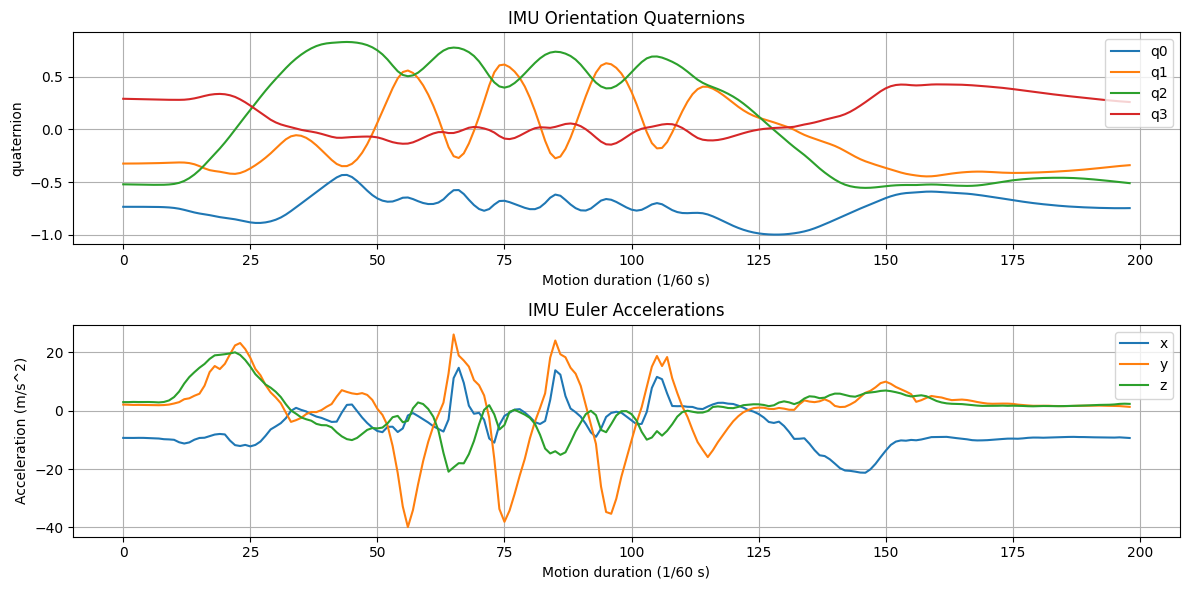

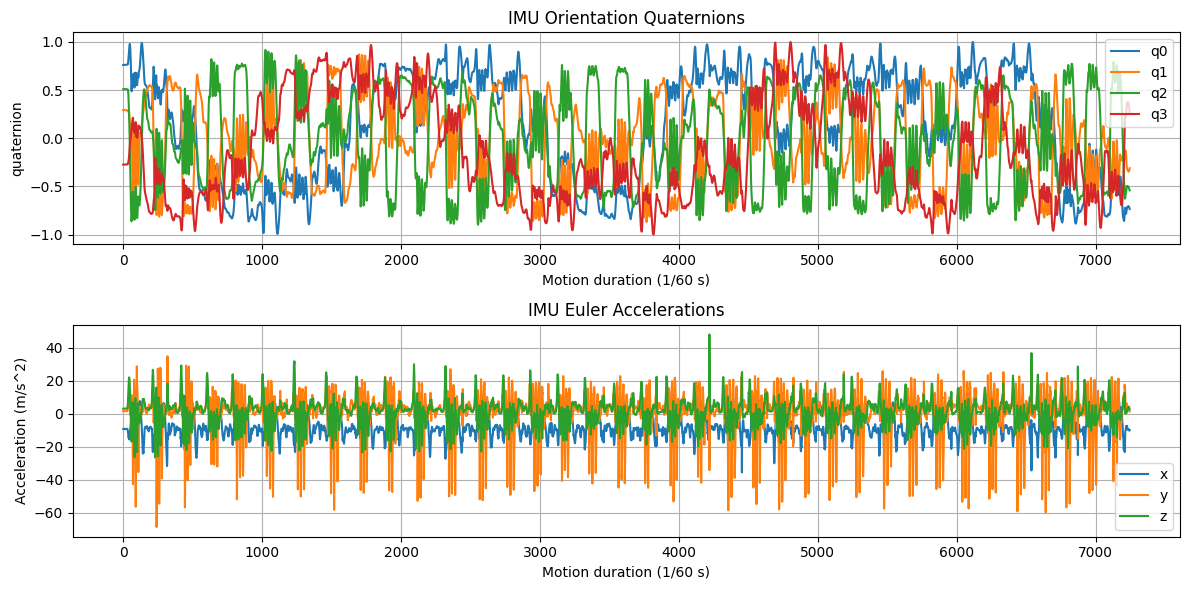

In [8]:
segmented_motion = data['005']['Segmented']['Wave']['000']['HAND']
continuous_motion_2 = data['005']['Continuous']['Wave']['000']['HAND']
print(segmented_motion.shape)
plot_motion(segmented_motion)
plot_motion(continuous_motion_2)


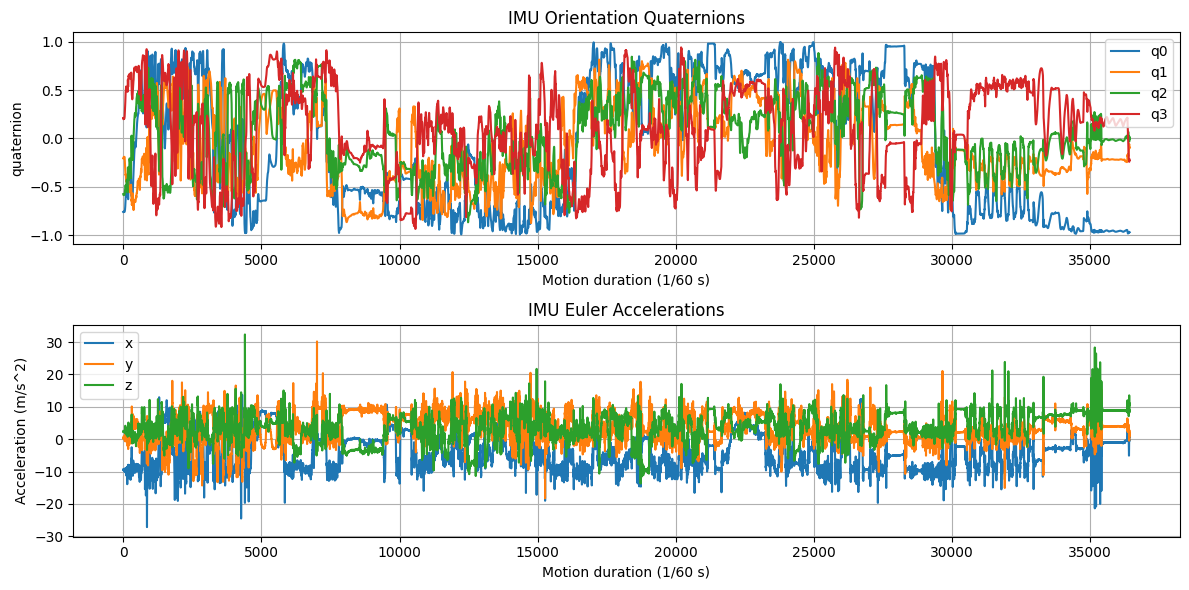

In [9]:
idle_motion_3 = data['005']['Idle']['Idle']['000']['HAND']
plot_motion(idle_motion_3)

## Data Preprocessing


In [10]:
def preprocess_data_sliding_windows(data, window_size=380, step_size=190):
    X, y = [], []
    
    for subject_id, rec_types in data.items():
        for rec_type, gestures in rec_types.items():
            if rec_type == 'Segmented':
                for gesture_class, trials in gestures.items():
                    for trial_number, segments in trials.items():
                        if 'HAND' in segments and 'fARM' in segments and 'uARM' in segments:
                            # to avoid packet loss
                            max_length = max(len(segments['HAND']), len(segments['fARM']), len(segments['uARM']))

                            hand_data = np.pad(segments['HAND'], ((0, max_length - len(segments['HAND'])), (0, 0)), mode='constant')
                            farm_data = np.pad(segments['fARM'], ((0, max_length - len(segments['fARM'])), (0, 0)), mode='constant')
                            uarm_data = np.pad(segments['uARM'], ((0, max_length - len(segments['uARM'])), (0, 0)), mode='constant')

                            imu_data = np.concatenate([hand_data, farm_data, uarm_data], axis=1) 

                            # ensure at least 1 window fit
                            if len(imu_data) < window_size:
                                imu_data = np.pad(imu_data, ((0, window_size - len(imu_data)), (0, 0)), mode='constant')

                            # Normalize features
                            scaler = StandardScaler()
                            imu_data_scaled = scaler.fit_transform(imu_data)

                            # Apply sliding window
                            for start in range(0, len(imu_data_scaled) - window_size + 1, step_size):
                                end = start + window_size
                                window = imu_data_scaled[start:end]
                                
                                X.append(window)
                                y.append(gesture_class)
    
   
    X = np.array(X)
    
    # One-hot encode labels
    labels = list(sorted(set(y)))
    y_encoded = np.array([labels.index(label) for label in y])
    y_one_hot = to_categorical(y_encoded, num_classes=len(labels))
    
    return X, y_one_hot, labels

window_size = 380  
step_size = int(window_size/2)  # 50% overlap of window_size

X, y_one_hot, labels = preprocess_data_sliding_windows(data, window_size, step_size)

print(f"Feature shape: {X.shape}")  # (num_samples, window_size, num_features)
print(f"Label shape: {y_one_hot.shape}")  # (num_samples, num_classes)
print(f"Labels: {labels}")

X_train, X_test, y_train, y_test = train_test_split(X, y_one_hot, test_size=0.2, random_state=42)


Feature shape: (2440, 380, 21)
Label shape: (2440, 10)
Labels: ['Angry', 'Cheer', 'Clap', 'Come', 'Crazy', 'Facepalm', 'Point', 'Salute', 'ThumbsUp', 'Wave']


In [11]:
# Convolutional Neural Network 1
def model_cnn_1(input_shape, num_classes):
    model = Sequential([
        # Convolutional Block 1
        Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=input_shape),
        BatchNormalization(),
        MaxPooling1D(pool_size=2),

        # Convolutional Block 2
        Conv1D(filters=128, kernel_size=3, activation='relu'),
        BatchNormalization(),
        MaxPooling1D(pool_size=2),

        # Convolutional Block 3
        Conv1D(filters=256, kernel_size=3, activation='relu'),
        BatchNormalization(),
        MaxPooling1D(pool_size=2),

        # Flatten and Fully Connected Layer
        Flatten(),
        Dense(512, activation='relu'),
        Dropout(0.5),

        # Output Layer
        Dense(num_classes, activation='softmax')
    ])
    
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [12]:
# Convolutional Neural Network 3
def model_cnn_2(input_shape, num_classes):
    model = Sequential([
        # Convolutional Block 1
        Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=input_shape),
        BatchNormalization(),
        MaxPooling1D(pool_size=2),
        Dropout(0.2),

        # Convolutional Block 2
        Conv1D(filters=128, kernel_size=3, activation='relu'),
        BatchNormalization(),
        MaxPooling1D(pool_size=2),
        Dropout(0.3),

        # Convolutional Block 3
        Conv1D(filters=256, kernel_size=3, activation='relu'),
        BatchNormalization(),
        MaxPooling1D(pool_size=2),
        Dropout(0.4),

        # Convolutional Block 4
        Conv1D(filters=512, kernel_size=3, activation='relu'),
        BatchNormalization(),
        MaxPooling1D(pool_size=2),
        Dropout(0.5),

        # Flatten and Fully Connected Layers
        Flatten(),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(128, activation='relu'),
        Dropout(0.5),

        # Output Layer
        Dense(num_classes, activation='softmax')
    ])
    
    model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])
    return model

In [13]:
def model_cnn_3(input_shape, num_classes):
    model = Sequential([
        # First Block
        Conv1D(filters=32, kernel_size=3, padding='same', activation='relu', input_shape=input_shape),
        BatchNormalization(),
        Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'),
        BatchNormalization(),
        MaxPooling1D(pool_size=2),
        Dropout(0.2),
        
        # Second Block
        Conv1D(filters=64, kernel_size=3, padding='same', activation='relu'),
        BatchNormalization(),
        Conv1D(filters=64, kernel_size=3, padding='same', activation='relu'),
        BatchNormalization(),
        MaxPooling1D(pool_size=2),
        Dropout(0.25),
        
        # Third Block
        Conv1D(filters=128, kernel_size=3, padding='same', activation='relu'),
        BatchNormalization(),
        Conv1D(filters=128, kernel_size=3, padding='same', activation='relu'),
        BatchNormalization(),
        MaxPooling1D(pool_size=2),
        Dropout(0.25),
        
        # Fourth Block
        Conv1D(filters=256, kernel_size=3, padding='same', activation='relu'),
        BatchNormalization(),
        Conv1D(filters=256, kernel_size=3, padding='same', activation='relu'),
        BatchNormalization(),
        MaxPooling1D(pool_size=2),
        Dropout(0.4),
        
        # Flatten and Fully Connected Layer
        Flatten(),
        Dense(256, activation='relu'),
        Dropout(0.5),
        
        # Output Layer
        Dense(num_classes, activation='softmax')
    ])
    
    model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])
    return model


In [14]:
def train_and_evaluate_cnn(X_train, y_train, X_test, y_test, model_cnn, labels, save_dir='best_model', initial_batch_size=32, epochs_per_step=30, steps=3):
    os.makedirs(save_dir, exist_ok=True)
    model_path = os.path.join(save_dir, f'cnn_best_model.keras')

    # Callbacks
    save_model = ModelCheckpoint(
        model_path, 
        save_best_only=True, 
        monitor='val_loss', 
        mode='min', 
        verbose=0
    )
    early_stopping = EarlyStopping(
        monitor='val_loss', 
        patience=10
    )
    reducelr = ReduceLROnPlateau(
        monitor='val_loss', 
        factor=0.8, 
        patience=3, 
        verbose=0, 
        mode='min', 
        min_lr=1e-5
    )

    # Build the CNN model
    input_shape = (X_train.shape[1], X_train.shape[2])  # (sequence_length, num_features)
    num_classes = y_train.shape[1]
    cnn_model = model_cnn(input_shape, num_classes)

    # Training with varying batch sizes
    full_history = {'loss': [], 'accuracy': [], 'val_loss': [], 'val_accuracy': []}

    batch_size = initial_batch_size
    for step in range(steps):
        print(f"\nTraining with batch size: {batch_size}")

        history = cnn_model.fit(
            X_train, y_train, 
            epochs=epochs_per_step, 
            validation_split=0.2, 
            batch_size=batch_size, 
            shuffle=True, 
            verbose=0, 
            callbacks=[save_model, early_stopping, reducelr]
        )

        # Append current history to full_history for train/val accuracy plot
        for key in full_history.keys():
            full_history[key].extend(history.history[key])

        batch_size *= 2

    # Load the best model
    cnn_model.load_weights(model_path)
    test_loss, test_accuracy = cnn_model.evaluate(X_test, y_test, verbose=0)
    print(f"Test Accuracy: {test_accuracy:.4f}")

    # Predict the classes
    y_pred = cnn_model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true = np.argmax(y_test, axis=1)

    # Create  and plot confusion matrix
    conf_matrix = confusion_matrix(y_true, y_pred_classes)
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.title(f'{model_cnn.__name__} Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()
    
    # Plot training & validation loss
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(full_history['loss'], label='Train Loss')
    plt.plot(full_history['val_loss'], label='Val Loss')
    plt.title(f'{model_cnn.__name__} Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot training & validation accuracy
    plt.subplot(1, 2, 2)
    plt.plot(full_history['accuracy'], label='Train Accuracy')
    plt.plot(full_history['val_accuracy'], label='Val Accuracy')
    plt.title(f'{model_cnn.__name__} Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

    return test_accuracy



Training with batch size: 32

Training with batch size: 64

Training with batch size: 128
Test Accuracy: 0.9795
16/16 [==============================] - 0s 2ms/step


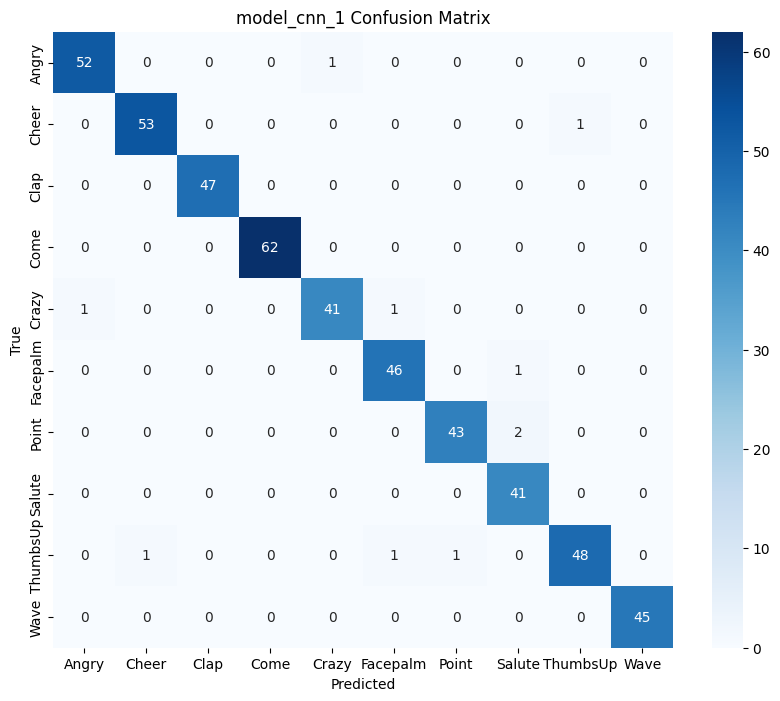

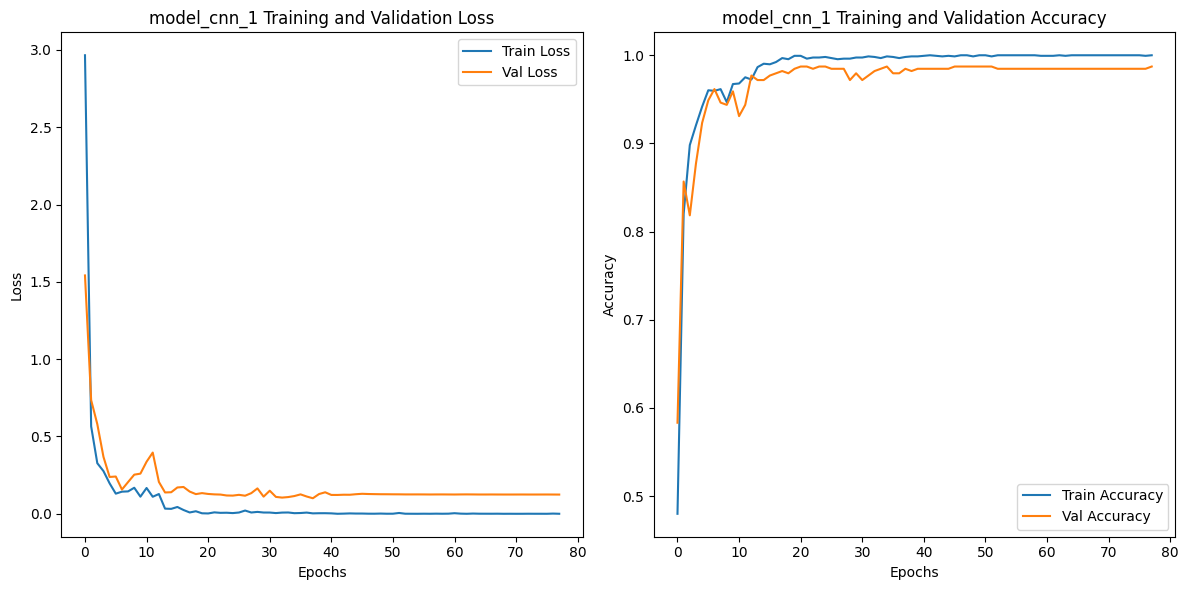

In [15]:
test_acc_1 = train_and_evaluate_cnn(X_train, y_train, X_test, y_test, model_cnn_1,labels)


Training with batch size: 32

Training with batch size: 64

Training with batch size: 128
Test Accuracy: 0.9857
16/16 [==============================] - 0s 2ms/step


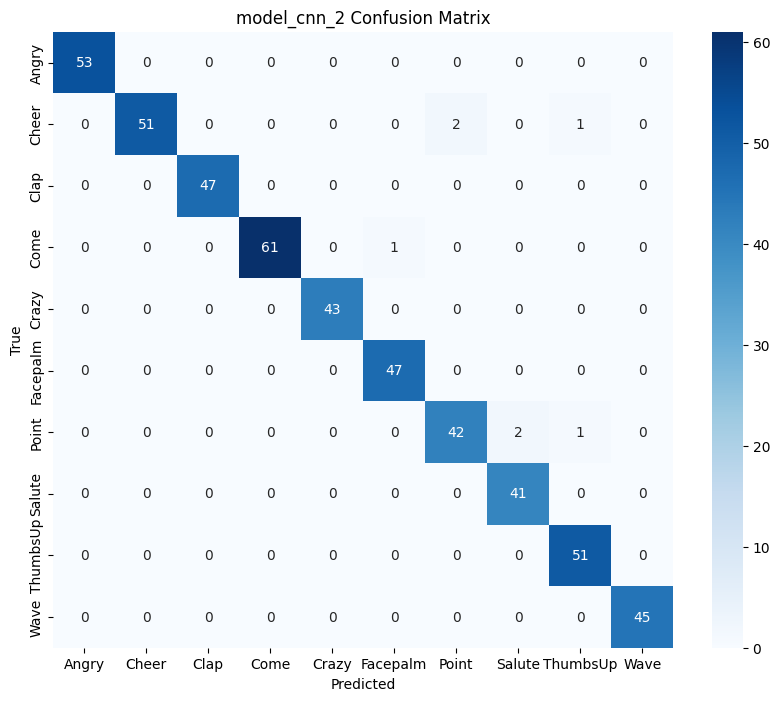

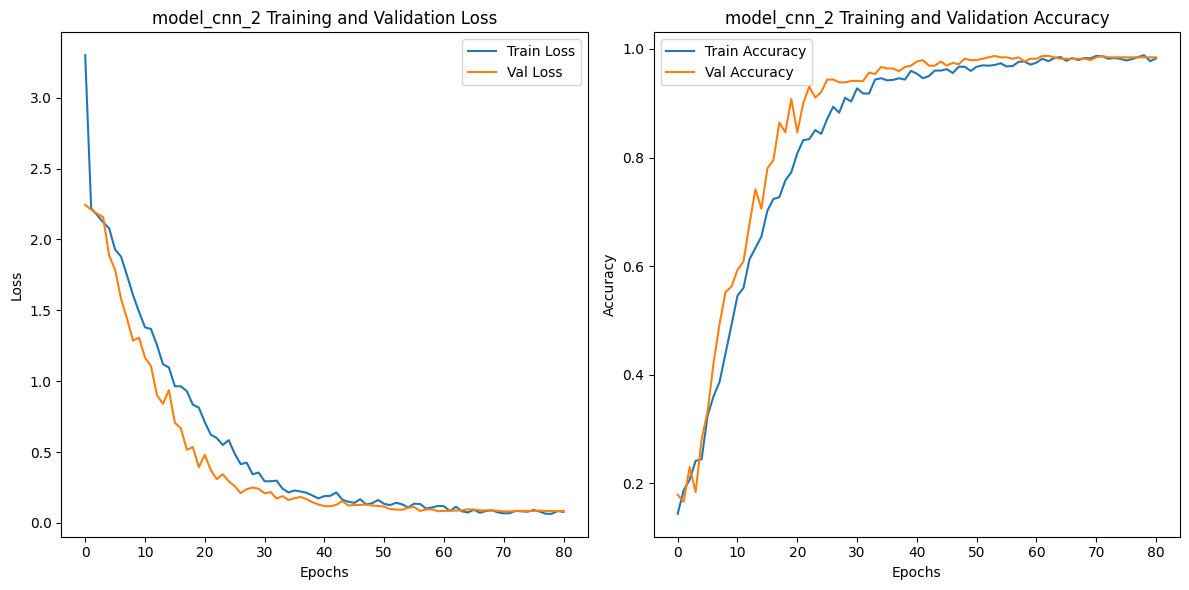

In [16]:
test_acc_2 = train_and_evaluate_cnn(X_train, y_train, X_test, y_test, model_cnn_2,labels)


Training with batch size: 32

Training with batch size: 64

Training with batch size: 128
Test Accuracy: 0.9877
16/16 [==============================] - 0s 2ms/step


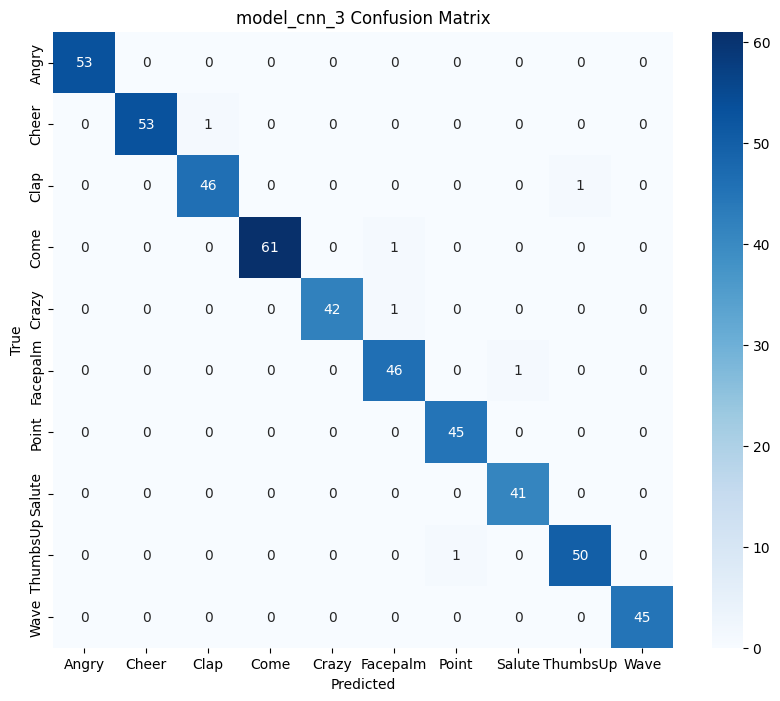

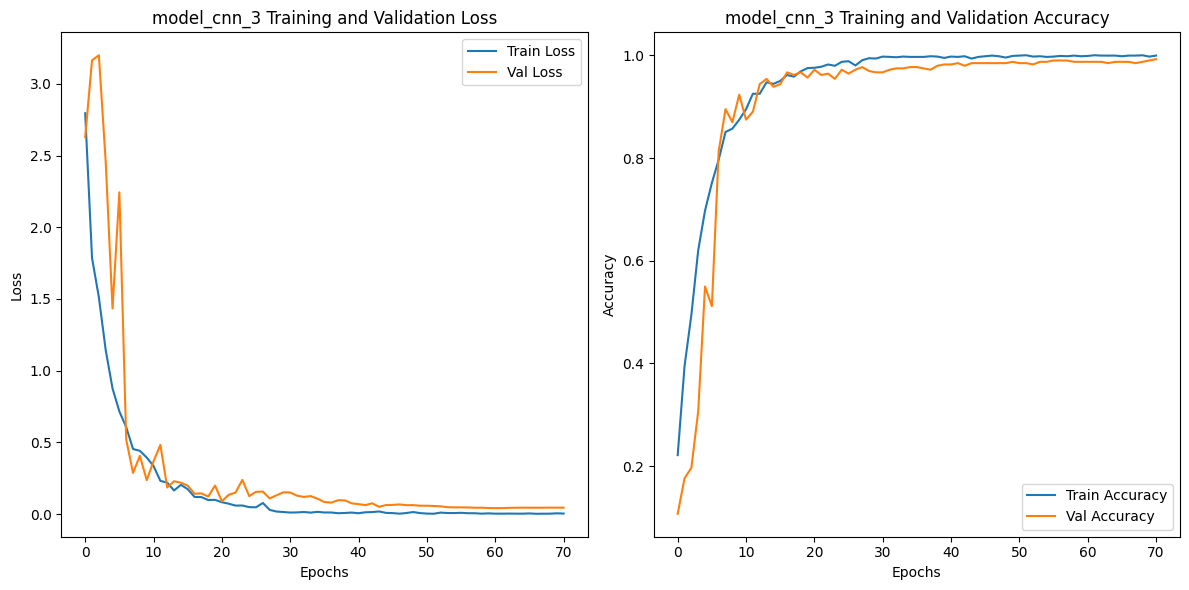

In [17]:
test_acc_3 = train_and_evaluate_cnn(X_train, y_train, X_test, y_test, model_cnn_3,labels)

In [18]:
accuracies = {
    'model_cnn_1': test_acc_1,
    'model_cnn_2': test_acc_2,
    'model_cnn_3': test_acc_3
}

best_model = max(accuracies, key=accuracies.get)
best_accuracy = accuracies[best_model]

print(f"Our best performing CNN was {best_model} with test accuracy of {best_accuracy * 100:.2f}%")

Our best performing CNN was model_cnn_3 with test accuracy of 98.77%


## LSTM

In [19]:
def lstm_model_1(input_shape, num_classes):
    model = Sequential()
    model.add(LSTM(64, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(0.2))
    model.add(LSTM(32, return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(num_classes, activation='softmax'))

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model


In [20]:
def lstm_model_2(input_shape, num_classes):
    model = Sequential()
    model.add(Bidirectional(LSTM(64, return_sequences=True), input_shape=input_shape))
    model.add(Dropout(0.3))
    model.add(Bidirectional(LSTM(32)))
    model.add(Dropout(0.3))
    model.add(Dense(num_classes, activation='softmax'))

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model



In [21]:
def lstm_model_3(input_shape, num_classes):
    inputs = Input(shape=input_shape)
    
    # First LSTM Layer with BatchNormalization
    x = LSTM(128, return_sequences=True)(inputs)
    x = BatchNormalization()(x)
    x = Dropout(0.4)(x)
    
    # Second LSTM Layer with BatchNormalization
    x = LSTM(64, return_sequences=True)(x)
    x = BatchNormalization()(x)
    x = Dropout(0.4)(x)
    
    # Global Average Pooling
    x = GlobalAveragePooling1D()(x)
    
    # Dense Layers
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.5)(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    
    model = Model(inputs=inputs, outputs=outputs)
    
    # Compile the model
    model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model


Training LSTM Model 1:

Epoch 1: val_loss improved from inf to 1.99733, saving model to model_best.h5

Epoch 2: val_loss improved from 1.99733 to 1.64267, saving model to model_best.h5

Epoch 3: val_loss improved from 1.64267 to 1.48715, saving model to model_best.h5

Epoch 4: val_loss improved from 1.48715 to 1.18113, saving model to model_best.h5

Epoch 5: val_loss did not improve from 1.18113

Epoch 6: val_loss improved from 1.18113 to 1.09739, saving model to model_best.h5

Epoch 7: val_loss improved from 1.09739 to 0.89347, saving model to model_best.h5

Epoch 8: val_loss did not improve from 0.89347

Epoch 9: val_loss improved from 0.89347 to 0.77192, saving model to model_best.h5

Epoch 10: val_loss improved from 0.77192 to 0.68007, saving model to model_best.h5
Test Accuracy: 0.7766
16/16 [==============================] - 1s 16ms/step


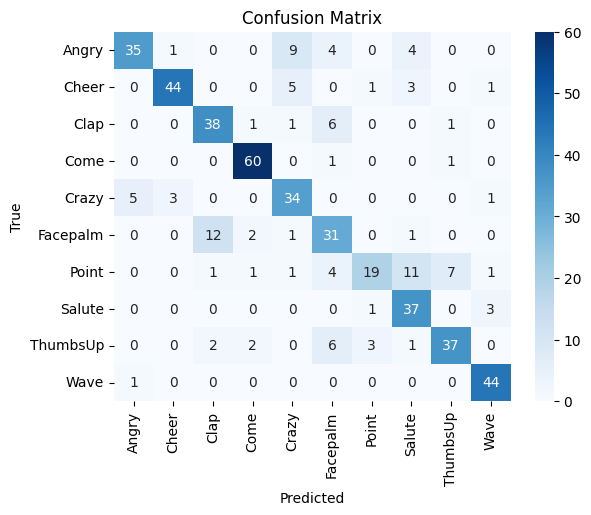

              precision    recall  f1-score   support

       Angry       0.85      0.66      0.74        53
       Cheer       0.92      0.81      0.86        54
        Clap       0.72      0.81      0.76        47
        Come       0.91      0.97      0.94        62
       Crazy       0.67      0.79      0.72        43
    Facepalm       0.60      0.66      0.63        47
       Point       0.79      0.42      0.55        45
      Salute       0.65      0.90      0.76        41
    ThumbsUp       0.80      0.73      0.76        51
        Wave       0.88      0.98      0.93        45

    accuracy                           0.78       488
   macro avg       0.78      0.77      0.76       488
weighted avg       0.79      0.78      0.77       488

Training LSTM Model 2:

Epoch 1: val_loss improved from inf to 1.94827, saving model to model_best.h5

Epoch 2: val_loss improved from 1.94827 to 1.48183, saving model to model_best.h5

Epoch 3: val_loss improved from 1.48183 to 1.08871, sav

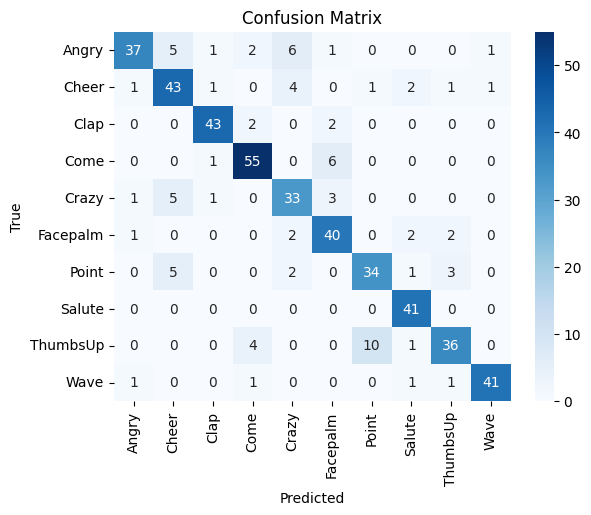

              precision    recall  f1-score   support

       Angry       0.90      0.70      0.79        53
       Cheer       0.74      0.80      0.77        54
        Clap       0.91      0.91      0.91        47
        Come       0.86      0.89      0.87        62
       Crazy       0.70      0.77      0.73        43
    Facepalm       0.77      0.85      0.81        47
       Point       0.76      0.76      0.76        45
      Salute       0.85      1.00      0.92        41
    ThumbsUp       0.84      0.71      0.77        51
        Wave       0.95      0.91      0.93        45

    accuracy                           0.83       488
   macro avg       0.83      0.83      0.83       488
weighted avg       0.83      0.83      0.82       488

Training LSTM Model 3:

Epoch 1: val_loss improved from inf to 2.18450, saving model to model_best.h5

Epoch 2: val_loss improved from 2.18450 to 1.79057, saving model to model_best.h5

Epoch 3: val_loss improved from 1.79057 to 1.20945, sav

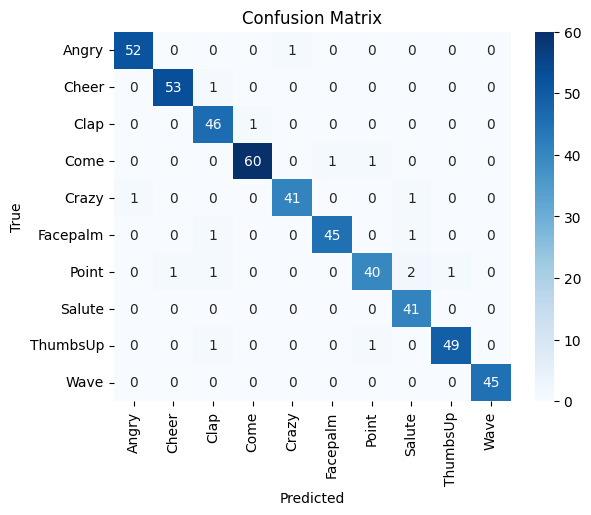

              precision    recall  f1-score   support

       Angry       0.98      0.98      0.98        53
       Cheer       0.98      0.98      0.98        54
        Clap       0.92      0.98      0.95        47
        Come       0.98      0.97      0.98        62
       Crazy       0.98      0.95      0.96        43
    Facepalm       0.98      0.96      0.97        47
       Point       0.95      0.89      0.92        45
      Salute       0.91      1.00      0.95        41
    ThumbsUp       0.98      0.96      0.97        51
        Wave       1.00      1.00      1.00        45

    accuracy                           0.97       488
   macro avg       0.97      0.97      0.97       488
weighted avg       0.97      0.97      0.97       488



In [22]:
window_size = 380
step_size = 190
input_shape = (window_size, 21) 
num_classes = len(labels)  

X, y_one_hot, labels = preprocess_data_sliding_windows(data, window_size, step_size)
X_train, X_test, y_train, y_test = train_test_split(X, y_one_hot, test_size=0.2, random_state=42)

def evaluate_model(model, X_test, y_test):
    test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
    print(f"Test Accuracy: {test_accuracy:.4f}")
    
    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true_classes = np.argmax(y_test, axis=1)
    
    cm = confusion_matrix(y_true_classes, y_pred_classes)
    #plt.figure(figsize=(10, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()
    
    report = classification_report(y_true_classes, y_pred_classes, target_names=labels)
    print(report)

def train_and_evaluate(model, X_train, y_train, X_test, y_test, epochs=10, model_name='model'):
    
    checkpoint = ModelCheckpoint(f'{model_name}_best.keras', 
                                 monitor='val_loss', 
                                 save_best_only=True, 
                                 mode='min', 
                                 verbose=1)
    
    
    history = model.fit(X_train, y_train, epochs=epochs, 
                        batch_size=32, 
                        validation_split=0.2, 
                        verbose=0, 
                        callbacks=[checkpoint])
    
    
    evaluate_model(model, X_test, y_test)


print("Training LSTM Model 1:")
model_1 = lstm_model_1(input_shape, num_classes)
train_and_evaluate(model_1, X_train, y_train, X_test, y_test)

print("Training LSTM Model 2:")
model_2 = lstm_model_2(input_shape, num_classes)
train_and_evaluate(model_2, X_train, y_train, X_test, y_test)

print("Training LSTM Model 3:")
model_3 = lstm_model_3(input_shape, num_classes)
train_and_evaluate(model_3, X_train, y_train, X_test, y_test)

### Hybrid Model (CNN, LSTM, Attention)

In [23]:
def hybrid_model(input_shape, num_classes):
    inputs = Input(shape=input_shape)
    
    # Convolutional Layer
    x = Conv1D(filters=64, kernel_size=3, activation='relu', padding='same')(inputs)
    x = MaxPooling1D(pool_size=2)(x)
    x = BatchNormalization()(x)
    
    # Bidirectional LSTM Layer
    x = Bidirectional(LSTM(128, return_sequences=True))(x)
    x = Dropout(0.4)(x)
    x = BatchNormalization()(x)
    
    # Another Bidirectional LSTM Layer
    x = Bidirectional(LSTM(64, return_sequences=True))(x)
    x = Dropout(0.4)(x)
    x = BatchNormalization()(x)
    
    # Attention Mechanism (proper usage)
    attention = Attention()([x, x])
    x = Concatenate()([x, attention])
    
    # Global Average Pooling
    x = GlobalAveragePooling1D()(x)
    
    # Dense Layers
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.5)(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    
    model = Model(inputs=inputs, outputs=outputs)
    
    # Compile the model
    model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model


Training LSTM Model 4:

Epoch 1: val_loss improved from inf to 2.13551, saving model to model_best.h5

Epoch 2: val_loss improved from 2.13551 to 1.46401, saving model to model_best.h5

Epoch 3: val_loss improved from 1.46401 to 0.79135, saving model to model_best.h5

Epoch 4: val_loss improved from 0.79135 to 0.32053, saving model to model_best.h5

Epoch 5: val_loss improved from 0.32053 to 0.19446, saving model to model_best.h5

Epoch 6: val_loss improved from 0.19446 to 0.09012, saving model to model_best.h5

Epoch 7: val_loss improved from 0.09012 to 0.08148, saving model to model_best.h5

Epoch 8: val_loss did not improve from 0.08148

Epoch 9: val_loss improved from 0.08148 to 0.06277, saving model to model_best.h5

Epoch 10: val_loss improved from 0.06277 to 0.04486, saving model to model_best.h5
Test Accuracy: 0.9734
16/16 [==============================] - 1s 19ms/step


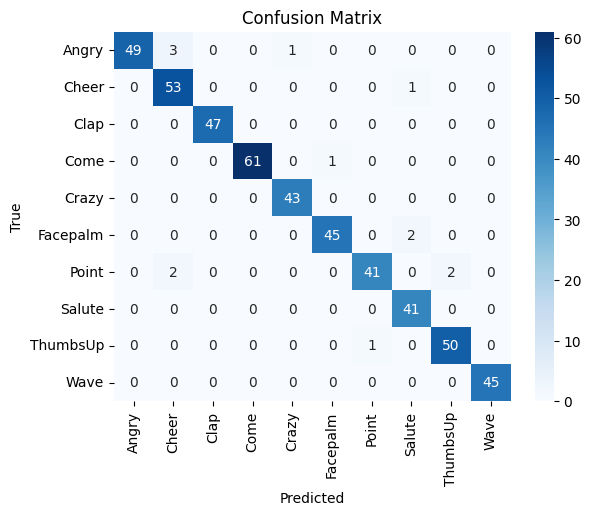

              precision    recall  f1-score   support

       Angry       1.00      0.92      0.96        53
       Cheer       0.91      0.98      0.95        54
        Clap       1.00      1.00      1.00        47
        Come       1.00      0.98      0.99        62
       Crazy       0.98      1.00      0.99        43
    Facepalm       0.98      0.96      0.97        47
       Point       0.98      0.91      0.94        45
      Salute       0.93      1.00      0.96        41
    ThumbsUp       0.96      0.98      0.97        51
        Wave       1.00      1.00      1.00        45

    accuracy                           0.97       488
   macro avg       0.97      0.97      0.97       488
weighted avg       0.97      0.97      0.97       488



In [24]:
print("Training LSTM Model 4:")
model_4 = hybrid_model(input_shape, num_classes)
train_and_evaluate(model_4, X_train, y_train, X_test, y_test)